In [ ]:
import kagglehub

path = kagglehub.dataset_download("tpotterer/motley-fool-scraped-earnings-call-transcripts")

print("Path to dataset files:", path)

In [2]:
import os
import pandas as pd

files = os.listdir(path)
print("Files found:", files)

pkl_path = os.path.join(path, "motley-fool-data.pkl")
df = pd.read_pickle(pkl_path)


Files found: ['motley-fool-data.pkl']


In [3]:
print(df.iloc[0])

date                                 Aug 27, 2020, 9:00 p.m. ET
exchange                                           NASDAQ: BILI
q                                                       2020-Q2
ticker                                                     BILI
transcript    Prepared Remarks:\nOperator\nGood day, and wel...
Name: 0, dtype: object


Put date in std format

In [4]:
df['date'] = (df['date']
                    .str.replace(" ET", "", regex=False)
                    .str.replace("p.m.", "PM", regex=False)
                    .str.replace("a.m.", "AM", regex=False))
df['date'] = pd.to_datetime(df['date'])
print(df["date"])

C:\Users\tnybe\AppData\Local\Temp\ipykernel_21636\543151239.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


0       2020-08-27 21:00:00
1       2020-07-30 16:30:00
2       2019-10-23 17:00:00
3       2019-11-06 12:00:00
4       2019-08-07 08:30:00
                ...        
18750   2021-11-09 13:00:00
18751   2021-11-18 12:00:00
18752   2022-02-08 11:00:00
18753   2022-02-28 16:30:00
18754   2021-08-12 09:00:00
Name: date, Length: 18755, dtype: datetime64[ns]


In [ ]:
import time
import pandas as pd
import yfinance as yf

list_of_companies = list(set(df["ticker"].unique()))

def get_bulk_data(tickers, start_date, end_date, batch_size=50):
    price_dict = {}

    for i in range(0, len(tickers), batch_size):
        batch = tickers[i : i + batch_size]
        print(f"Downloading batch {i//batch_size + 1} of {len(tickers)//batch_size + 1}...")

        try:
            data = yf.download(batch, start=start_date, end=end_date, progress=False)
            print(data.head())
            data = data["Close"]
            print(data.head())
            for ticker in batch:
                if ticker in data.columns.get_level_values(0):
                    ticker_df = data[ticker].dropna(how='all')
                    if not ticker_df.empty:
                        price_dict[ticker] = ticker_df

        except Exception as e:
            print(f"Error in batch starting with {batch[0]}: {e}")

        time.sleep(20)

    return price_dict

all_data_dict = get_bulk_data(list_of_companies, "2019-01-01", "2024-06-01")


In [ ]:
print(all_data_dict)

In [7]:
def get_year_return(row):
    ticker = row['ticker']
    buy_date = row['date'] + pd.Timedelta(days=1)
    sell_date = row['date'] + pd.DateOffset(years=1)

    if ticker not in all_data_dict:
        return None
    ticker_series = all_data_dict[ticker]

    try:
        valid_days = ticker_series.loc[buy_date:sell_date]

        if len(valid_days) < 2:
            return None

        begin_price = valid_days.iloc[0]
        end_price = valid_days.iloc[-1]

        return (end_price - begin_price) / begin_price

    except Exception as e:
        return None

df["year_return"] = df.apply(get_year_return, axis=1)




In [8]:
df.dropna(subset=['year_return'], inplace=True)

print(f"Remaining rows: {len(df)}")
print(f"Remaining NaNs: {df['year_return'].isna().sum()}")

Remaining rows: 15033
Remaining NaNs: 0


In [9]:
output_path = "motley_fool_dropna.pkl"
df.to_pickle(output_path)

In [ ]:
sector_etf_map = {
    'Technology': 'XLK',
    'Communication Services': 'XLC',
    'Healthcare': 'XLV',
    'Financial Services': 'XLF',
    'Consumer Cyclical': 'XLY',
    'Consumer Defensive': 'XLP',
    'Industrials': 'XLI',
    'Utilities': 'XLU',
    'Energy': 'XLE',
    'Basic Materials': 'XLB',
    'Real Estate': 'XLRE'
}

print("Downloading Sector ETF data...")
etf_tickers = list(sector_etf_map.values()) + ['SPY']
etf_data = yf.download(etf_tickers, start="2019-01-01", end="2025-01-01")['Close']
print("ETF Data Downloaded.")

unique_tickers = df['ticker'].unique()
ticker_sector_map = {}

print(f"Fetching sector info for {len(unique_tickers)} companies. This might take a moment...")

for i, ticker in enumerate(unique_tickers):
    try:

        info = yf.Ticker(ticker).info
        sector = info.get('sector', 'Unknown')

        etf_ticker = sector_etf_map.get(sector, 'SPY')
        ticker_sector_map[ticker] = etf_ticker

    except Exception as e:
        print(f"Could not find sector for {ticker}, defaulting to SPY")
        ticker_sector_map[ticker] = 'SPY'

    if i % 50 == 0 and i > 0:
        time.sleep(1)

print("Sector mapping complete.")



def get_relative_return(row):
    stock_return = row['year_return']
    if pd.isna(stock_return):
        return None

    ticker = row['ticker']
    benchmark_ticker = ticker_sector_map.get(ticker, 'SPY')

    buy_date = row['date'] + pd.Timedelta(days=1)
    sell_date = row['date'] + pd.DateOffset(years=1)

    try:

        benchmark_series = etf_data[benchmark_ticker]
        valid_days = benchmark_series.loc[buy_date:sell_date]

        if len(valid_days) < 2:
            return None

        begin_price = valid_days.iloc[0]
        end_price = valid_days.iloc[-1]

        benchmark_return = (end_price - begin_price) / begin_price

        return stock_return - benchmark_return

    except Exception as e:
        return None

# Apply the function
print("Calculating relative returns...")
df['relative_year_return'] = df.apply(get_relative_return, axis=1)

# Inspect the data
print(df[['ticker', 'date', 'year_return', 'relative_year_return']].head())

In [11]:
output_path = "motley_fool_rel_return.pkl"
df.to_pickle(output_path)
print(f"Saved masked dataframe to {output_path}")

Saved masked dataframe to motley_fool_rel_return.pkl


THIS WILL TAKE >12 HOURS

In [1]:
import pandas as pd
df = pd.read_pickle("motley_fool_rel_return.pkl")

In [2]:
import spacy

spacy.require_gpu()

nlp = spacy.load(
    "en_core_web_trf",
    disable=["tagger", "parser", "attribute_ruler", "lemmatizer"]
)

def apply_mask(doc):
    text = doc.text
    replacements = []

    for ent in doc.ents:
        if ent.label_ in ["ORG", "PERSON"]:
            replacements.append((ent.start_char, ent.end_char, f"<{ent.label_}>"))

    replacements.sort(key=lambda x: x[0], reverse=True)

    new_text = text
    for start, end, tag in replacements:
        new_text = new_text[:start] + tag + new_text[end:]

    return new_text

C:\Users\tnybe\PycharmProjects\stock-screener\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from tqdm import tqdm


print("Processing on GPU...")

texts_with_index = [
    (i, str(text))
    for i, text in enumerate(df['transcript'].fillna(""))
]

texts_with_index.sort(key=lambda x: len(x[1]), reverse=True)

sorted_indices = [x[0] for x in texts_with_index]
sorted_texts = [x[1] for x in texts_with_index]

doc_generator = nlp.pipe(sorted_texts, batch_size=1)

masked_transcripts_map = {}

for i, doc in tqdm(enumerate(doc_generator), total=len(sorted_texts), desc="Masking Transcripts"):
    masked_text = apply_mask(doc)

    original_idx = sorted_indices[i]
    masked_transcripts_map[original_idx] = masked_text

df['transcript_masked'] = df.index.map(masked_transcripts_map)

print("Done!")

In [ ]:

print(df.iloc[5]["transcript"])


In [ ]:
print(df.iloc[5]["transcript_masked"])

In [6]:
output_path = "motley_fool_masked_post_mask.pkl"
df.to_pickle(output_path)

In [3]:
import pandas as pd
df = pd.read_pickle("motley_fool_masked_post_mask.pkl")

In [ ]:
print(df.iloc[1]["transcript_masked"])

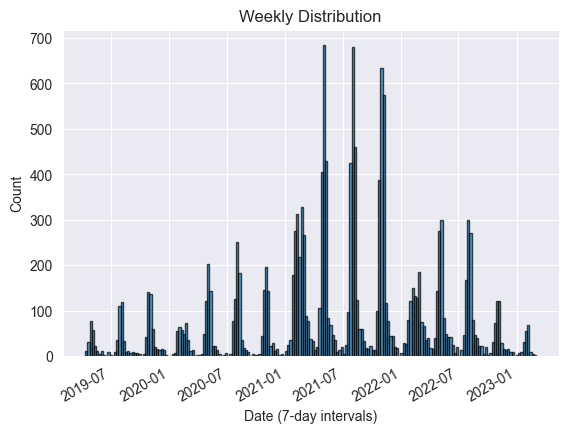

In [5]:
import matplotlib.pyplot as plt
bins = pd.date_range(start=df['date'].min(),
                     end=df['date'].max() + pd.Timedelta(days=7),
                     freq='7D')

plt.hist(df['date'], bins=bins, edgecolor='black', alpha=0.7)

plt.title('Weekly Distribution')
plt.xlabel('Date (7-day intervals)')
plt.ylabel('Count')

plt.gcf().autofmt_xdate()

plt.show()



In [7]:
print(df.iloc[0])

date                                                  2020-08-27 21:00:00
exchange                                                     NASDAQ: BILI
q                                                                 2020-Q2
ticker                                                               BILI
transcript              Prepared Remarks:\nOperator\nGood day, and wel...
year_return                                                      0.594286
relative_year_return                                             0.245279
transcript_masked       Prepared Remarks:\nOperator\nGood day, and wel...
Name: 0, dtype: object


In [ ]:
rows_with_nan = df[df.isna().any(axis=1)]
print(rows_with_nan)

In [9]:
output_path = "motley_fool_masked.pkl"
df.to_pickle(output_path)

In [10]:
print(df.head(1))

                 date      exchange        q ticker  \
0 2020-08-27 21:00:00  NASDAQ: BILI  2020-Q2   BILI   

                                          transcript  year_return  \
0  Prepared Remarks:\nOperator\nGood day, and wel...     0.594286   

   relative_year_return                                  transcript_masked  
0              0.245279  Prepared Remarks:\nOperator\nGood day, and wel...  


In [ ]:
final_df = df[['date', 'ticker', 'transcript_masked', 'relative_year_return']].copy()
final_df = final_df.dropna(subset=['relative_year_return'])
print(final_df.head(20))

In [12]:
output_path = "motley_fool_masked.pkl"
final_df.to_pickle(output_path)

In [23]:
final_df = pd.read_pickle("motley_fool_masked.pkl")

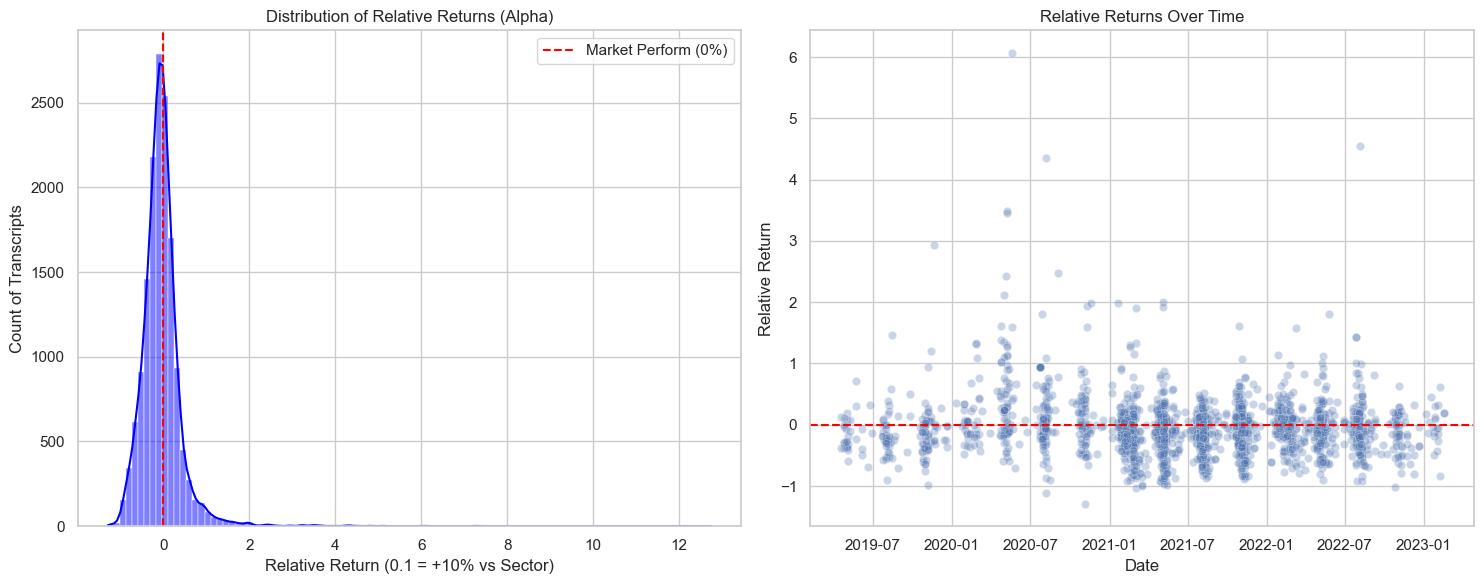

Statistics for Relative Returns:
count    15033.000000
mean        -0.041799
std          0.478934
min         -1.287422
25%         -0.284447
50%         -0.070489
75%          0.133537
max         12.745342
Name: relative_year_return, dtype: float64


In [25]:

import seaborn as sns

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.histplot(final_df['relative_year_return'], bins=100, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of Relative Returns (Alpha)')
axes[0].set_xlabel('Relative Return (0.1 = +10% vs Sector)')
axes[0].set_ylabel('Count of Transcripts')
axes[0].axvline(0, color='red', linestyle='--', label='Market Perform (0%)')
axes[0].legend()

sns.scatterplot(data=final_df.sample(min(len(final_df), 2000)), x='date', y='relative_year_return', alpha=0.3, ax=axes[1])
axes[1].set_title('Relative Returns Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Relative Return')
axes[1].axhline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

print("Statistics for Relative Returns:")
print(final_df['relative_year_return'].describe())

In [26]:

yearly_stats = final_df.groupby(final_df['date'].dt.year)['relative_year_return'].agg(['mean', 'std'])
print("Yearly Statistics (Notice how 2020 has higher std dev):")
print(yearly_stats)

Yearly Statistics (Notice how 2020 has higher std dev):
          mean       std
date                    
2019 -0.051918  0.558356
2020  0.203473  0.756541
2021 -0.106568  0.341314
2022 -0.051246  0.435116
2023 -0.092744  0.392759


In [27]:
def calculate_z_score(x):
    return (x - x.mean()) / x.std()

final_df['standardized_return'] = final_df.groupby(final_df['date'].dt.year)['relative_year_return'].transform(calculate_z_score)

In [ ]:
print(final_df.head())
final_df['year'] = final_df['date'].dt.year
print(final_df.head())

In [ ]:


final_df['return_percentile'] = final_df.groupby('year')['relative_year_return'].transform(
    lambda x: x.rank(pct=True)
)

print(final_df[['date', 'relative_year_return', 'standardized_return', 'return_percentile', 'ticker', 'transcript_masked']].head())

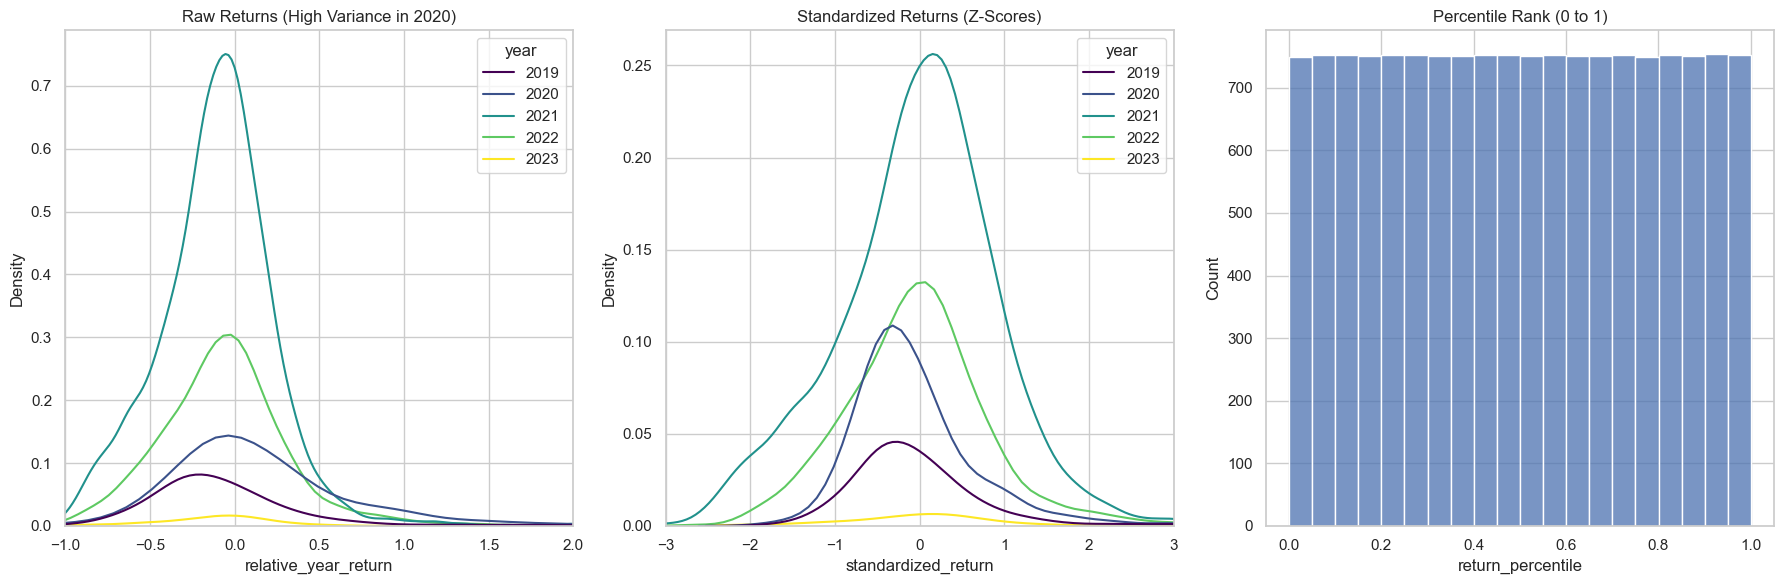

In [30]:

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.kdeplot(data=final_df, x='relative_year_return', hue='year', palette='viridis', ax=axes[0], warn_singular=False)
axes[0].set_title('Raw Returns (High Variance in 2020)')
axes[0].set_xlim(-1, 2)

sns.kdeplot(data=final_df, x='standardized_return', hue='year', palette='viridis', ax=axes[1], warn_singular=False)
axes[1].set_title('Standardized Returns (Z-Scores)')
axes[1].set_xlim(-3, 3)

sns.histplot(data=final_df, x='return_percentile', bins=20, ax=axes[2])
axes[2].set_title('Percentile Rank (0 to 1)')

plt.tight_layout()
plt.show()

In [31]:
output_path = "motley_fool_masked.pkl"
final_df.to_pickle(output_path)

In [32]:
print(final_df.head())

                 date ticker  \
0 2020-08-27 21:00:00   BILI   
1 2020-07-30 16:30:00    GFF   
2 2019-10-23 17:00:00   LRCX   
3 2019-11-06 12:00:00   BBSI   
4 2019-08-07 08:30:00   CSTE   

                                   transcript_masked  relative_year_return  \
0  Prepared Remarks:\nOperator\nGood day, and wel...              0.245279   
1  Prepared Remarks:\nOperator\nThank you for sta...             -0.436972   
2  Prepared Remarks:\nOperator\nGood day and welc...             -0.113156   
3  Prepared Remarks:\nOperator\nGood day, everyon...             -0.293707   
4  Prepared Remarks:\nOperator\nGreetings and wel...             -0.355823   

   standardized_return  year  return_percentile  
0             0.055259  2020           0.670070  
1            -0.846544  2020           0.082754  
2            -0.109676  2019           0.541154  
3            -0.433038  2019           0.308420  
4            -0.544284  2019           0.233680  
